In [2]:
import utils
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

## Counting bridges

In [3]:
@njit()
def dfs(v, neighbors, used, bridges, fup, tin, timer, p=-1):
    used[v] = True
    timer[0] += 1
    tin[v] = timer[0]
    fup[v] = timer[0]
    for i in range(1, neighbors[v, 0]+1):
        to = neighbors[v, i]
        if p == to:
            continue

        if used[to]:
            fup[v] = min(fup[v], tin[to])
        else:
            dfs(to, neighbors, used, bridges, fup, tin, timer, v)
            fup[v] = min(fup[v], fup[to])
            if fup[to] > tin[v]:
                bridges[v] = True
                bridges[to] = True

@njit()
def find_bridges(neighbors):
    """
    finds bridges
    
    Returns
    -------
    bridges_spins: np.array(L) bool
        True if spin is in a bridge
    """
    n = neighbors.shape[0]
    used = np.zeros(n, dtype=np.bool_)
    bridges = np.zeros(n, dtype=np.bool_)
    timer = np.zeros(1, dtype=np.int32) # crutch
    fup = np.zeros(n, dtype=np.int32)
    tin = np.zeros(n, dtype=np.int32)
    
    for i in range(n):
        if not used[i]:
            dfs(i, neighbors, used, bridges, fup, tin, timer)
    
    # add spins connecting bridges and clusters to clusters
    bridges_cpy = bridges.copy()
    for i in range(n):
        if bridges_cpy[i]:
            for j in range(1, neighbors[i, 0]+1):
                if not bridges_cpy[neighbors[i, j]]:
                    bridges[i] = False
                    break
    return bridges
    

@njit()
def dfs_len_bridges(v, neighbors, used, bridges_spins):
    l = 1
    used[v] = True
    for i in range(1, neighbors[v, 0]+1):
        to = neighbors[v, i]
        if used[to] or not bridges_spins[to]:
            continue
            
        l += dfs_len_bridges(to, neighbors, used, bridges_spins)
        
    return l

@njit()
def dfs_size_clusters(v, neighbors, used, bridges_spins):
    s = 1
    used[v] = True
    for i in range(1, neighbors[v, 0]+1):
        to = neighbors[v, i]
        if used[to] or bridges_spins[to]:
            continue
            
        s += dfs_size_clusters(to, neighbors, used, bridges_spins)
        
    return s
    
@njit()
def shape_data(neighbors):
    """
    Calculates number and size of clusters and bridges (1D sigments)
    Bridge - set of connected spins such that if you remove one of them the graph will split into two
    Cluster - set of conected spins that can be removed without splitting graph
    
    Parameters
    ----------
    neighbors: np.array(L, :) int
        list of neighbors
        neighbors[i, 0] = number of neghbors
        
    Returns
    -------
    clusters: np.array(:) int
        sizes of clusters
        
    bridges: np.array(:) int
        sizes of bridges
        
    bridges_spins: np.array(L) bool
        True if spin is in a bridge
    """
    bridges_spins = find_bridges(neighbors)
    
    n = neighbors.shape[0]
    used = np.zeros(n, dtype=np.bool_)
    
    cluster_count = 0
    bridges_count = 0
    clusters = np.zeros(n, dtype=np.int32)
    bridges = np.zeros(n, dtype=np.int32)
    for i in range(n):
        if not used[i]:
            if bridges_spins[i]:
                bridges[bridges_count] = dfs_len_bridges(i, neighbors, used, bridges_spins)
                bridges_count += 1
                
            else:
                clusters[cluster_count] = dfs_size_clusters(i, neighbors, used, bridges_spins)
                cluster_count += 1
    
    clusters = clusters[:cluster_count]
    bridges = bridges[:bridges_count]
    
    return clusters, bridges, bridges_spins

In [6]:
conformations = utils.load_Conformations_from_dir('Conformations/L1000_beta0.1_1_10(1000)', load_data=True)

In [15]:
neighbors = utils.tabulate_neighbors(conformations[0].struct)

small test

In [16]:
br = find_bridges(neighbors)

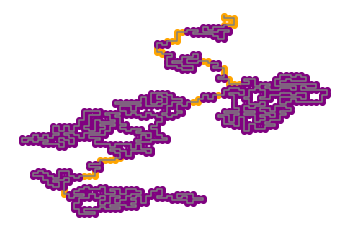

In [17]:
utils.draw_conformation(conformations[0].struct, bridges=br)

In [18]:
c, b, b_s = shape_data(neighbors)

In [19]:
c

array([168,  45,   8, 348,   9, 280,   4,   6,  35,   4,   6,  34])

Find clasters in all conformations

In [20]:
k = 0
clusters = []
bridges = []
for conf in conformations:
    k += 1
    if k % 100 == 0:
        print(k)
    neighbors = utils.tabulate_neighbors(conf.struct)
    c, b, b_s = shape_data(neighbors)
    clusters.append(c)
    bridges.append(b)

100
200
300
400
500
600
700
800
900
1000


In [21]:
clusters[0].shape

(12,)

In [22]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    points[i] = (conformations[i].R_norm, clusters[i].shape[0])


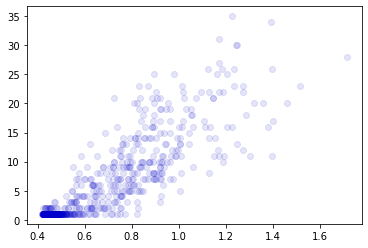

In [23]:
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.1) )

In [24]:
k = 0
clusters = []
bridges = []
for conf in conformations:
    k += 1
    if k % 100 == 0:
        print(k)
    neighbors = utils.tabulate_neighbors(conf.struct)
    c, b, b_s = shape_data(neighbors)
    clusters.append(c)
    bridges.append(b)

100
200
300
400
500
600
700
800
900
1000


In [25]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    points[i] = (conformations[i].R_norm, clusters[i].shape[0])


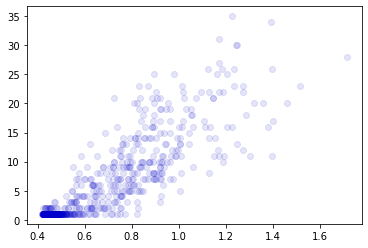

In [26]:
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.1));

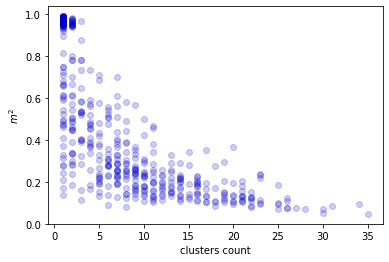

In [27]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    points[i] = (clusters[i].shape[0], conformations[i].mag2[-1].mean)

plt.xlabel('clusters count')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.2));

92


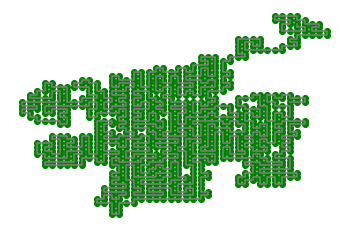

460


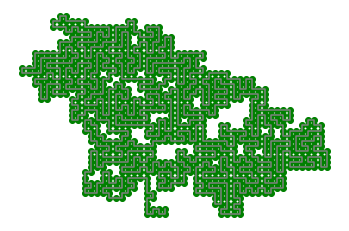

In [28]:
for i in range(len(conformations)):
    if clusters[i].shape[0] > 2 and conformations[i].mag2[-1].mean > 0.8:
        print(i)
        utils.draw_conformation(conformations[i].struct)

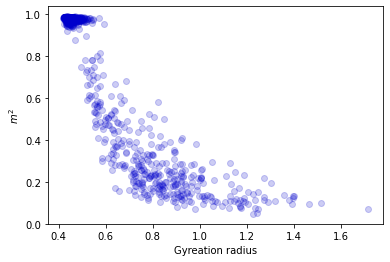

In [29]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    points[i] = (conformations[i].R_norm, conformations[i].mag2[-1].mean)

plt.xlabel('Gyreation radius')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.2));

#202, R = 0.585089026698224, m^2=0.2982981952866888
clusters: [782 179   4   6   4   4]
bridges: [12  2  1  4  1  2]


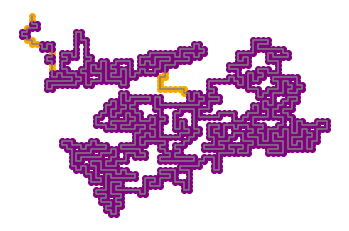

#234, R = 0.5945443467537183, m^2=0.38805877253016197
clusters: [940   4   8  38]
bridges: [1 2 8]


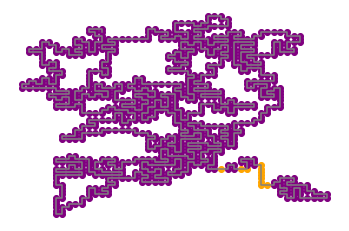

#837, R = 0.5851384788051115, m^2=0.31208643401013253
clusters: [1001]
bridges: []


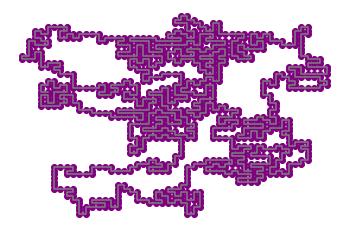

In [30]:
for i in range(len(conformations)):
    if conformations[i].R_norm < 0.6 and  conformations[i].mag2[-1].mean < 0.4:
        print('#{}, R = {}, m^2={}'.format(i, conformations[i].R_norm, conformations[i].mag2[-1].mean))
        print('clusters:', clusters[i])
        print('bridges:', bridges[i])
        _, _, bs = shape_data(utils.tabulate_neighbors(conformations[i].struct))
        utils.draw_conformation(conformations[i].struct, bridges=bs)

As seen in pictures above. Serchig for classic bridges does not achieve the desired result. 

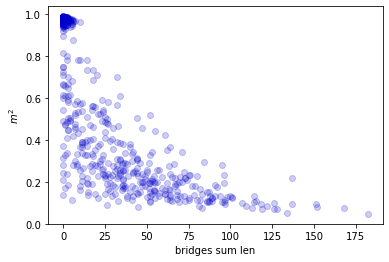

In [31]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    points[i] = (bridges[i].sum(), conformations[i].mag2[-1].mean)

plt.xlabel('bridges sum len')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.2));

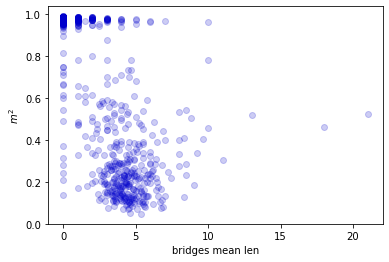

In [32]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    if bridges[i].shape[0] == 0:
        points[i] = (0, conformations[i].mag2[-1].mean)
    else:
        points[i] = (bridges[i].mean(), conformations[i].mag2[-1].mean)

plt.xlabel('bridges mean len')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.2));

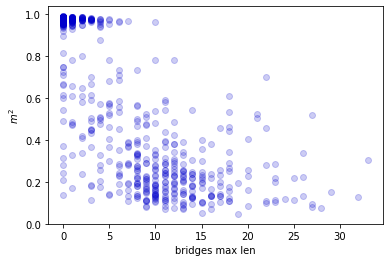

In [33]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    if bridges[i].shape[0] == 0:
        points[i] = (0, conformations[i].mag2[-1].mean)
    else:
        points[i] = (bridges[i].max(), conformations[i].mag2[-1].mean)

plt.xlabel('bridges max len')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.2));

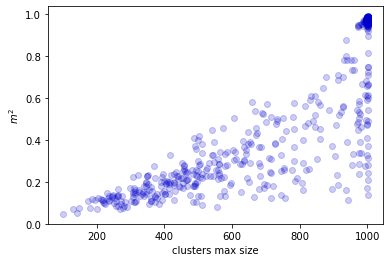

In [34]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    if clusters[i].shape[0] == 0:
        points[i] = (0, conformations[i].mag2[-1].mean)
    else:
        points[i] = (clusters[i].max(), conformations[i].mag2[-1].mean)

plt.xlabel('clusters max size')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.2));

## Counting 1D segments

In [49]:
@njit()
def find_1D_sigments(neighbors):
    bridges = np.zeros(neighbors.shape[0], np.bool_)
    for i in range(neighbors.shape[0]):
        if neighbors[i, 0] < 3:
            bridges[i] = True
            
    # add spins connecting bridges and clusters to clusters
#     bridges_cpy = bridges.copy()
#     for i in range(neighbors.shape[0]):
#         if bridges_cpy[i]:
#             for j in range(1, neighbors[i, 0]+1):
#                 if not bridges_cpy[neighbors[i, j]]:
#                     bridges[i] = False
#                     break

    for i in range(neighbors.shape[0]):
        if not bridges[i]:
            continue
        if i == 0 or i == neighbors.shape[0]-1:
            continue
        
        p = i-1
        n = i+1
        if bridges[p] or bridges[n]:
            continue
        
        for j in range(1, 1+neighbors[p, 0]):
            for k in range(1, 1+neighbors[n, 0]):
                if neighbors[p, j] == neighbors[n, k] and neighbors[p, j] != i:
                    bridges[i] = False
                    break
            
            if not bridges[i]:
                break
    
    
    return bridges
    
    
@njit()
def clusters_and_lines(neighbors):
    """
    Calculates number and size of clusters and bridges (1D sigments)
    Bridge - set of connected spins such that if you remove one of them the graph will split into two
    Cluster - set of conected spins that can be removed without splitting graph
    
    Parameters
    ----------
    neighbors: np.array(L, :) int
        list of neighbors
        neighbors[i, 0] = number of neghbors
        
    Returns
    -------
    clusters: np.array(:) int
        sizes of clusters
        
    bridges: np.array(:) int
        sizes of bridges
        
    bridges_spins: np.array(L) bool
        True if spin is in a bridge
    """
    bridges_spins = find_1D_sigments(neighbors)
    
    n = neighbors.shape[0]
    used = np.zeros(n, dtype=np.bool_)
    
    cluster_count = 0
    bridges_count = 0
    clusters = np.zeros(n, dtype=np.int32)
    bridges = np.zeros(n, dtype=np.int32)
    for i in range(n):
        if not used[i]:
            if bridges_spins[i]:
                bridges[bridges_count] = dfs_len_bridges(i, neighbors, used, bridges_spins)
                bridges_count += 1
                
            else:
                clusters[cluster_count] = dfs_size_clusters(i, neighbors, used, bridges_spins)
                cluster_count += 1
    
    clusters = clusters[:cluster_count]
    bridges = bridges[:bridges_count]
    
    
    
    return clusters, bridges, bridges_spins
    

@njit()
def find_1D_sigments_2(neighbors):
    bridges = np.zeros(neighbors.shape[0], np.bool_)
    for i in range(neighbors.shape[0]):
        if neighbors[i, 0] < 3:
            bridges[i] = True
    
    return bridges
@njit()
def dfs_size_clusters_2(v, neighbors, used, bridges_spins, cb_id, cluster):
    s = 1
    cb_id[v] = cluster
    used[v] = True
    for i in range(1, neighbors[v, 0]+1):
        to = neighbors[v, i]
        if used[to] or bridges_spins[to]:
            continue
            
        s += dfs_size_clusters_2(to, neighbors, used, bridges_spins, cb_id, cluster)
        
    return s
    
@njit()
def clusters_and_bridges(neighbors):
    """
    Calculates number and size of clusters and bridges (1D sigments)
    Bridge - set of onnected spins with 2 or less neighbors
    Cluster - set of connected spins that are not in bridges
    
    bridges must connect different clusters
    
    Parameters
    ----------
    neighbors: np.array(L, :) int
        list of neighbors
        neighbors[i, 0] = number of neghbors
        
    Returns
    -------
    clusters: np.array(:) int
        sizes of clusters
        
    bridges: np.array(:) int
        sizes of bridges
        
    bridges_spins: np.array(L) bool
        True if spin is in a bridge
    """
    bridges_spins = find_1D_sigments_2(neighbors)
    
    n = neighbors.shape[0]
    
    used = np.zeros(n, dtype=np.bool_)
    
    cluster_count = 0
    bridges_count = 0
    clusters = np.zeros(n, dtype=np.int32)
    bridges = np.zeros(n, dtype=np.int32)
    
    cl_id = np.zeros(n, dtype=np.int32)
    
    bridge_len = 0
    last_c = -1
    for i in range(n):
        if bridges_spins[i]:
            used[i] = True
            bridge_len += 1
        else:
            if used[i]:
                if bridge_len > 0:
                    if cl_id[i] == last_c: # bridge connects the same cluster
                        for k in range(i-bridge_len, i):
                            bridges_spins[k] = False
                            cl_id[k] = cl_id[i]
                        clusters[cluster_count-1] += bridge_len
                    else:
                        bridges[bridges_count] = bridge_len
                        bridges_count += 1 
            else:
                if bridge_len > 0:
                    bridges[bridges_count] = bridge_len
                    bridges_count += 1

                clusters[cluster_count] = dfs_size_clusters_2(i, neighbors, used, bridges_spins, cl_id, cluster_count)
                cluster_count += 1
                
            last_c = cl_id[i]
            bridge_len = 0
    
    if bridge_len > 0:
        bridges[bridges_count] = bridge_len
        bridges_count += 1
    
    clusters = clusters[:cluster_count]
    bridges = bridges[:bridges_count]
    
    return clusters, bridges, bridges_spins

In [50]:
def clusters_and_lines_from_list(conformations):
    k = 0
    clusters = []
    bridges = []
    for conf in conformations:
        k += 1
        if k % 100 == 0:
            print(k)
        neighbors = utils.tabulate_neighbors(conf.struct)
        c, b, b_s = clusters_and_lines(neighbors)
        clusters.append(c)
        bridges.append(b)
        
    return clusters, bridges

In [51]:
def clusters_and_lines_from_list_2(conformations):
    k = 0
    clusters = []
    bridges = []
    for conf in conformations:
        k += 1
        if k % 100 == 0:
            print(k)
        neighbors = utils.tabulate_neighbors(conf.struct)
        c, b, b_s = clusters_and_bridges(neighbors)
        clusters.append(c)
        bridges.append(b)
        
    return clusters, bridges

In [9]:
clusters, bridges = clusters_and_lines_from_list(conformations)

100
200
300
400
500
600
700
800
900
1000


#202, R = 0.585089026698224, m^2=0.2982981952866888
clusters: [ 97 165  33  15  23 308   4  17 136   4  10   2   6   2   2]
bridges: [ 1  9  3  2  5  1  2  1  2  2  2  3  3  2  1  1  1  1  1  1  2  1  1  6
  1  2  1  2  3  2  2  2  2  3  2  2  2  1  2  1  2  3  2  6  2  2  3  2
  2  3  3  2  1  3 12  2  2  2  5  2  2  1  2  4  2  2  1  2  2  2  1  4
  2  1  2  2]


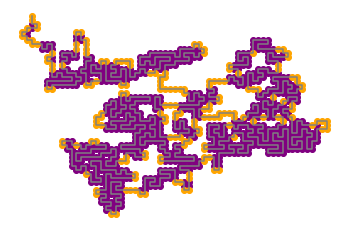

#234, R = 0.5945443467537183, m^2=0.38805877253016197
clusters: [ 45   6 430   6  10   2 139   4  12  26  76   4   2   6  30   4]
bridges: [ 2  2  1  2  2  2  2  2  2  6  2  2  1  2 12  1  6  2  2  3  2  2  2  2
  1  2  3  2  1  1  5  2  5  6  2  5 10 13  2  3  2  6 15  2  1  1  2  2
 11  2  7  1  1  1  2  2  2  8  1  2  1]


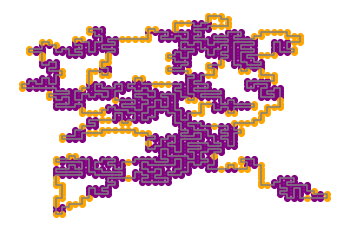

#837, R = 0.5851384788051115, m^2=0.31208643401013253
clusters: [ 87 479   6  12  40  17  39   2  19   6   6  12   2  12  14  19  36]
bridges: [ 1  6  2  2  1  2  2  2  2  2  2  4  2  4  3  2  2  4  2 11  1  8  2  1
  2 10  2  2  6  2  2  2  3  9 16  2  8  2  5  7  2  1  1  2  1  2  3  2
  2  1  2  5  3  2  2  8  2  2]


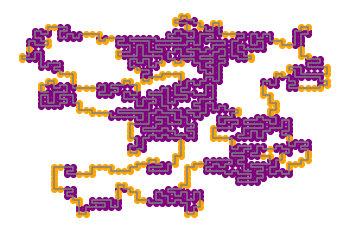

In [10]:
for i in range(len(conformations)):
    if conformations[i].R_norm < 0.6 and  conformations[i].mag2[-1].mean < 0.4:
        print('#{}, R = {}, m^2={}'.format(i, conformations[i].R_norm, conformations[i].mag2[-1].mean))
        print('clusters:', clusters[i])
        print('bridges:', bridges[i])
        _, _, bs = clusters_and_lines(utils.tabulate_neighbors(conformations[i].struct))
        utils.draw_conformation(conformations[i].struct, bridges=bs)

In [58]:
clusters, bridges = clusters_and_lines_from_list_2(conformations)

100
200
300
400
500
600
700
800
900
1000


#202, R = 0.585089026698224, m^2=0.2982981952866888
clusters: [ 86 155  39  17  73 282  62  25 151   6  15   4   6   4   4]
bridges: [ 1  9  5  1  1  2  1  1  1  3  2  2  3  2  3  3  3 12  4  2  1  2  1  4
  1]


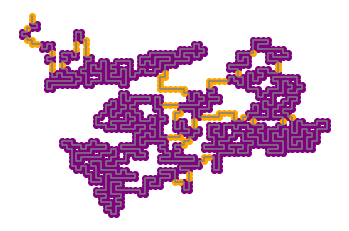

#234, R = 0.5945443467537183, m^2=0.38805877253016197
clusters: [ 48  10 418   6  35   4 149  29  18  32  77  17   4   8  28   8]
bridges: [ 1  2  2  1 12  3  2  1  5  5  6 13  3  6 15  1 11  7  1  1  2  8  1  1]


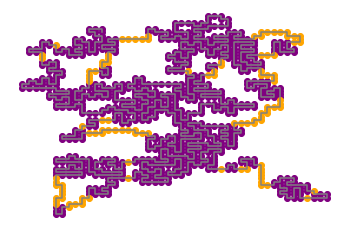

#837, R = 0.5851384788051115, m^2=0.31208643401013253
clusters: [ 79 459  19  14  60  27  43   4  21   6   6  48   4  12  16  21  50]
bridges: [ 1  1  2  4  4 11  1  8  2  1 10  6  2  3  9 16  8  1  3  2  1  5  3  8]


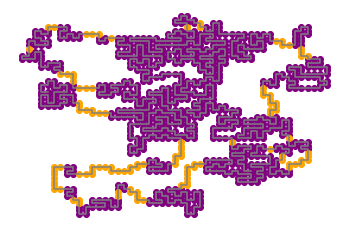

In [59]:
for i in range(len(conformations)):
    if conformations[i].R_norm < 0.6 and  conformations[i].mag2[-1].mean < 0.4:
        print('#{}, R = {}, m^2={}'.format(i, conformations[i].R_norm, conformations[i].mag2[-1].mean))
        print('clusters:', clusters[i])
        print('bridges:', bridges[i])
        _, _, bs = clusters_and_bridges(utils.tabulate_neighbors(conformations[i].struct))
        utils.draw_conformation(conformations[i].struct, bridges=bs)

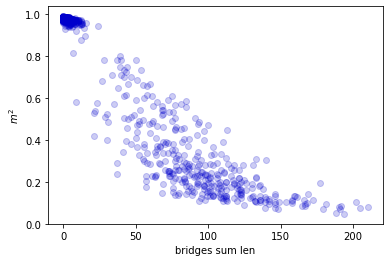

In [60]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    points[i] = (bridges[i].sum(), conformations[i].mag2[-1].mean)

plt.xlabel('bridges sum len')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.2));

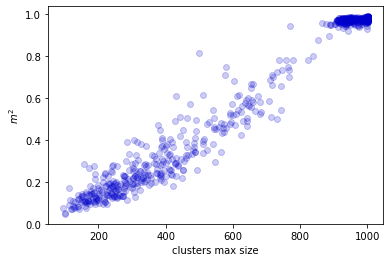

In [61]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    if clusters[i].shape[0] == 0:
        points[i] = (0, conformations[i].mag2[-1].mean)
    else:
        points[i] = (clusters[i].max(), conformations[i].mag2[-1].mean)

plt.xlabel('clusters max size')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.2));

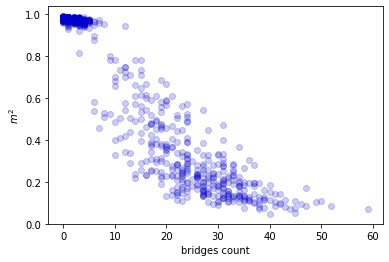

In [62]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    points[i] = (bridges[i].shape[0], conformations[i].mag2[-1].mean)

plt.xlabel('bridges count')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.2));

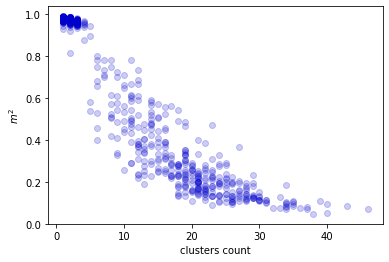

In [64]:
points = []
for i in range(len(conformations)):
#     if conformations[i].R_norm < 0.7:
        points.append((clusters[i].shape[0], conformations[i].mag2[-1].mean))

points = np.array(points)
plt.xlabel('clusters count')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.2));

## Cluster statistics

In [52]:
conformations = utils.load_Conformations_from_dir('Conformations/L1000_beta0.1_1_10(10000)', load_data=True)

In [56]:
L = 1000

In [53]:
clusters, bridges = clusters_and_lines_from_list_2(conformations)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


In [71]:
# check
for i in range(len(clusters)):
    if clusters[i].sum() + bridges[i].sum() != conformations[i].L:
        print(i, clusters[i].sum() + bridges[i].sum())
        _, _, bs = clusters_and_bridges(utils.tabulate_neighbors(conformations[i].struct))
        utils.draw_conformation(conformations[i].struct, bridges=bs)
        print(bs.sum(), bridges[i].sum())
        break

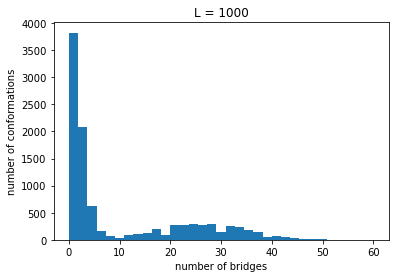

In [72]:
bridges_count = [b.shape[0] for b in bridges]
plt.title(f'L = {L}')
plt.xlabel('number of bridges')
plt.ylabel('number of conformations')
plt.hist(bridges_count, bins='auto')
plt.show()

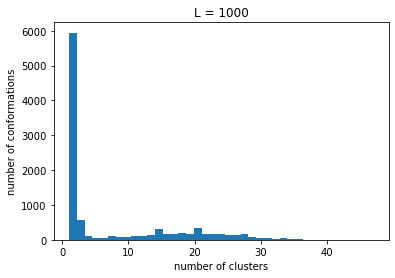

In [73]:
clusters_count = [c.shape[0] for c in clusters]
plt.title(f'L = {L}')
plt.xlabel('number of clusters')
plt.ylabel('number of conformations')
plt.hist(clusters_count, bins='auto')
plt.show()

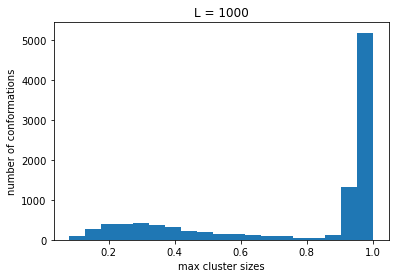

In [74]:
max_cluster = [c.max() / L for c in clusters]
plt.title(f'L = {L}')
plt.xlabel('max cluster sizes')
plt.ylabel('number of conformations')
plt.hist(max_cluster, bins='auto')
plt.show()

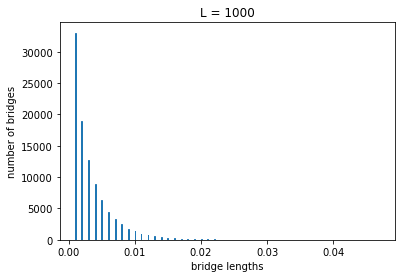

In [75]:
bridge_lengths = []
for br in bridges:
    for b in br:
        bridge_lengths.append(b / L)
plt.title(f'L = {L}')
plt.xlabel('bridge lengths')
plt.ylabel('number of bridges')
plt.hist(bridge_lengths, bins='auto', histtype='step')
plt.show()

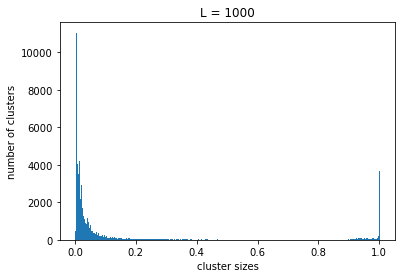

In [76]:
cluster_sizes = []
for cl in clusters:
    for c in cl:
        cluster_sizes.append(c / L)
plt.title(f'L = {L}')
plt.xlabel('cluster sizes')
plt.ylabel('number of clusters')
plt.hist(cluster_sizes, bins='auto')
plt.show()

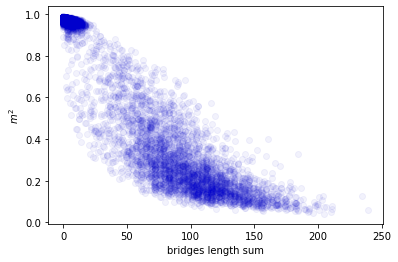

In [63]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    points[i] = (bridges[i].sum(), conformations[i].mag2[-1].mean)

plt.xlabel('bridges length sum')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.05));

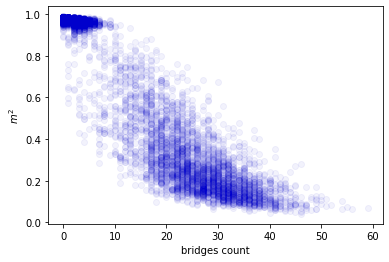

In [9]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    points[i] = (bridges[i].shape[0], conformations[i].mag2[-1].mean)

plt.xlabel('bridges count')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.05));

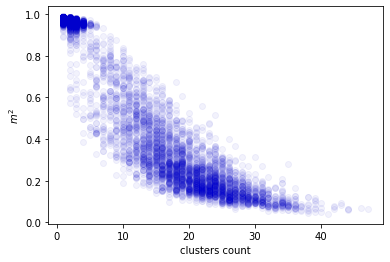

In [10]:
points = []
for i in range(len(conformations)):
#     if conformations[i].R_norm < 0.7:
        points.append((clusters[i].shape[0], conformations[i].mag2[-1].mean))

points = np.array(points)
plt.xlabel('clusters count')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.05));

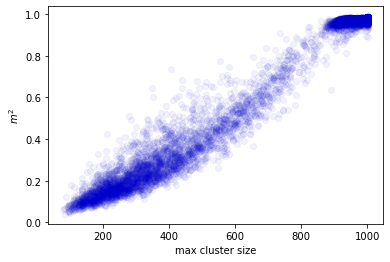

In [11]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    if clusters[i].shape[0] == 0:
        points[i] = (0, conformations[i].mag2[-1].mean)
    else:
        points[i] = (clusters[i].max(), conformations[i].mag2[-1].mean)

plt.xlabel('max cluster size')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.05));

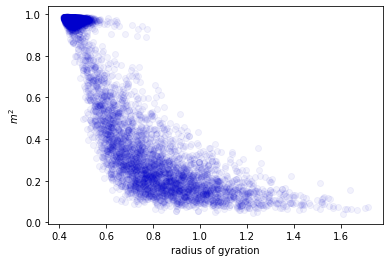

In [12]:
points = []
for i in range(len(conformations)):
    points.append((conformations[i].R_norm, conformations[i].mag2[-1].mean))

points = np.array(points)
plt.xlabel('radius of gyration')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.05));

In [64]:
Max_C = []
for i in range(len(clusters)):
    Max_C.append((clusters[i].max(), i))
    
R_norm = []
for i in range(len(conformations)):
    R_norm.append((conformations[i].R_norm, i))

In [65]:
R_norm.sort()
Max_C.sort(reverse=True)

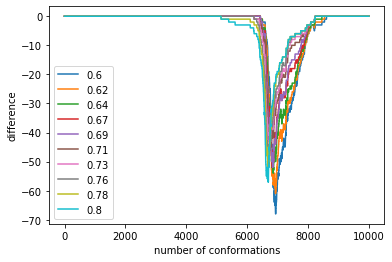

In [70]:
plt.figure()
plt.xlabel('number of conformations')
plt.ylabel('difference')
for m_th in np.linspace(0.6, 0.8, 10):
    k_c = 0
    k_r = 0
    C_arr = []
    R_arr = []
    N = 10000
    step = 200
    for i in range(N):
        if conformations[R_norm[i][1]].mag2[-1].mean < m_th:
            k_r += 1
        if conformations[Max_C[i][1]].mag2[-1].mean < m_th:
            k_c += 1

        C_arr.append(k_c)
        R_arr.append(k_r)

#         if i % step == 0:
#             print(i, f'k_r = {k_r}, k_c = {k_c}, dif = {k_r - k_c}, {i - k_c}')
    
    plt.plot([C_arr[i] - R_arr[i] for i in range(len(C_arr))], label='{:.2}'.format(m_th))

plt.legend(loc='best')
plt.show()

## Length 500

In [78]:
conformations = utils.load_Conformations_from_dir('Conformations/L500_beta0.1_1_10(10000)', load_data=True)

In [79]:
clusters, bridges = clusters_and_lines_from_list_2(conformations)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


In [86]:
L = 500

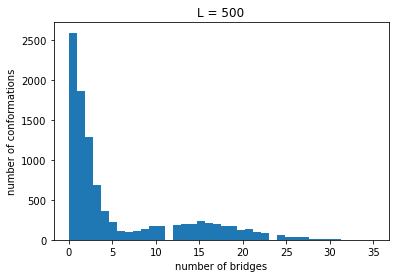

In [87]:
bridges_count = [b.shape[0] for b in bridges]
plt.title(f'L = {L}')
plt.xlabel('number of bridges')
plt.ylabel('number of conformations')
plt.hist(bridges_count, bins='auto')
plt.show()

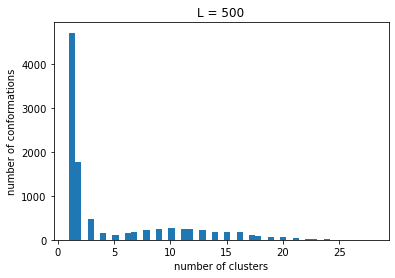

In [88]:
clusters_count = [c.shape[0] for c in clusters]
plt.title(f'L = {L}')
plt.xlabel('number of clusters')
plt.ylabel('number of conformations')
plt.hist(clusters_count, bins='auto')
plt.show()

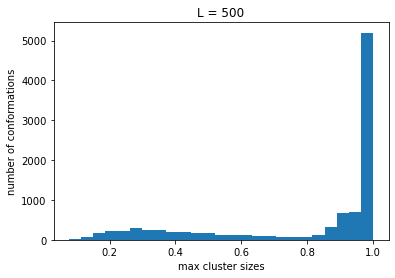

In [89]:
max_cluster = [c.max() / L for c in clusters]
plt.title(f'L = {L}')
plt.xlabel('max cluster sizes')
plt.ylabel('number of conformations')
plt.hist(max_cluster, bins='auto')
plt.show()

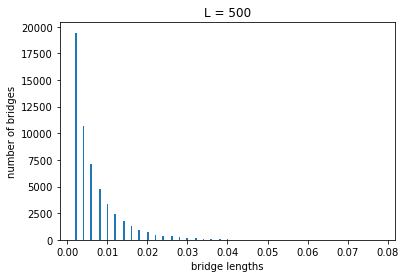

In [92]:
bridge_lengths = []
for br in bridges:
    for b in br:
        bridge_lengths.append(b / L)
plt.title(f'L = {L}')
plt.xlabel('bridge lengths')
plt.ylabel('number of bridges')
plt.hist(bridge_lengths, bins='auto')
plt.show()

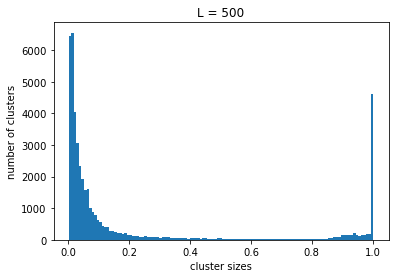

In [93]:
cluster_sizes = []
for cl in clusters:
    for c in cl:
        cluster_sizes.append(c / L)
plt.title(f'L = {L}')
plt.xlabel('cluster sizes')
plt.ylabel('number of clusters')
plt.hist(cluster_sizes, bins='auto')
plt.show()

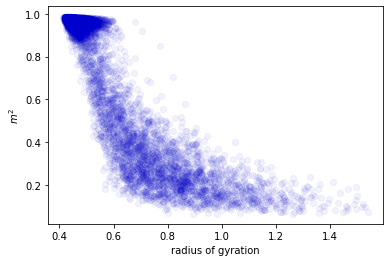

In [10]:
points = []
for i in range(len(conformations)):
    points.append((conformations[i].R_norm, conformations[i].mag2[-1].mean))

points = np.array(points)
plt.xlabel('radius of gyration')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.05));

0.679207757145841 0.9631265156717018 0.00011037771596108828


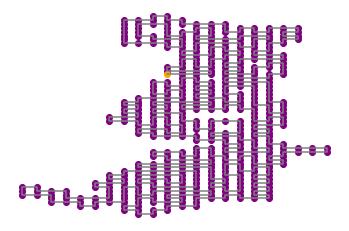

0.7717729244744584 0.8492195075354048 0.0005278782034013679


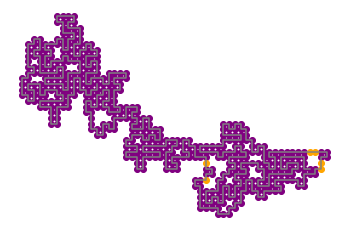

0.7038032352904667 0.9185812536983861 0.00027536283049990986


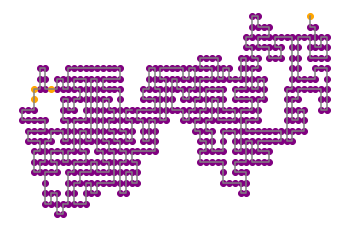

In [14]:
for i in range(len(conformations)):
    if conformations[i].R_norm > 0.65 and conformations[i].mag2[-1].mean > 0.8:
        print(conformations[i].R_norm, conformations[i].mag2[-1].mean, conformations[i].mag2[-1].errorbar)
        _, _, bs = clusters_and_bridges(utils.tabulate_neighbors(conformations[i].struct))
        utils.draw_conformation(conformations[i].struct, bridges=bs)


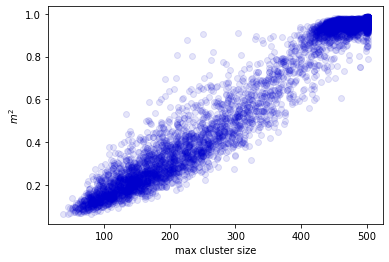

In [11]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    if clusters[i].shape[0] == 0:
        points[i] = (0, conformations[i].mag2[-1].mean)
    else:
        points[i] = (clusters[i].max(), conformations[i].mag2[-1].mean)

plt.xlabel('max cluster size')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.1));

308 0.8066351132150207 0.0005500545895471705


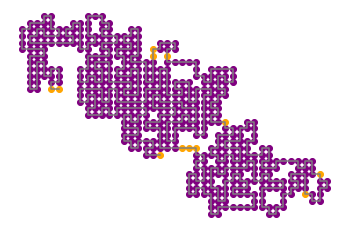

304 0.9114762825151564 0.00042281740274034593


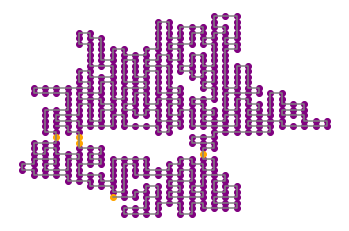

211 0.8067771831473934 0.0004422344676130395


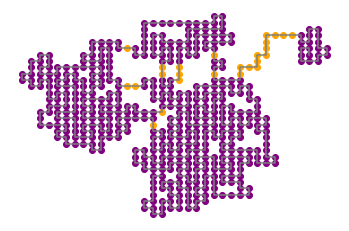

234 0.8020600499324665 0.0005733312443800526


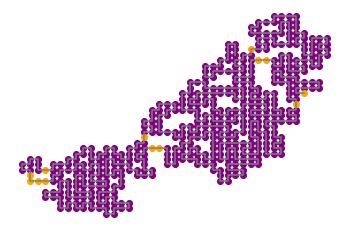

266 0.8207934083189591 0.0004568546484520103


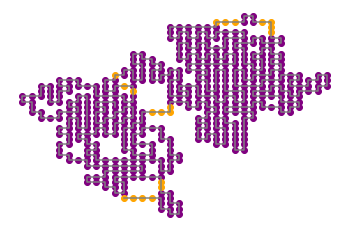

251 0.9069255697582711 0.0004369697986828936


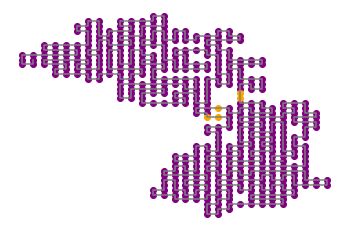

227 0.8774426060899382 0.000436689849569408


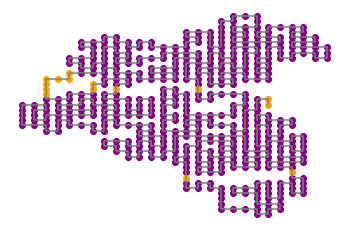

329 0.880829912888171 0.00045967581390650696


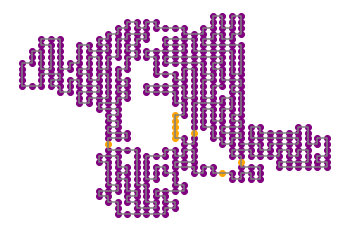

In [12]:
for i in range(len(conformations)):
    if clusters[i].max() < 330 and conformations[i].mag2[-1].mean > 0.8:
        print(clusters[i].max(), conformations[i].mag2[-1].mean, conformations[i].mag2[-1].errorbar)
        _, _, bs = clusters_and_bridges(utils.tabulate_neighbors(conformations[i].struct))
        utils.draw_conformation(conformations[i].struct, bridges=bs)


461 0.6048838038215473 0.0005906253257711717


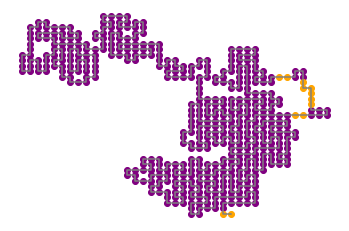

In [16]:
for i in range(len(conformations)):
    if clusters[i].max() > 450 and conformations[i].mag2[-1].mean < 0.65:
        print(clusters[i].max(), conformations[i].mag2[-1].mean, conformations[i].mag2[-1].errorbar)
        _, _, bs = clusters_and_bridges(utils.tabulate_neighbors(conformations[i].struct))
        utils.draw_conformation(conformations[i].struct, bridges=bs)


In [21]:
Max_C = []
for i in range(len(clusters)):
    Max_C.append((clusters[i].max(), i))
    
R_norm = []
for i in range(len(conformations)):
    R_norm.append((conformations[i].R_norm, i))

In [22]:
R_norm.sort()
Max_C.sort(reverse=True)

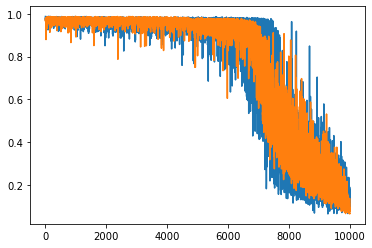

In [38]:
m_R = [conformations[x[1]].mag2[-1].mean for x in R_norm]
m_C = [conformations[x[1]].mag2[-1].mean for x in Max_C]
plt.plot(m_R)
plt.plot(m_C)

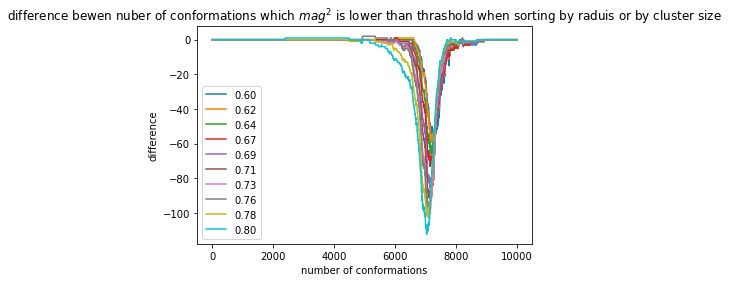

In [34]:
plt.figure()
plt.title(r'difference bewen nuber of conformations which $mag^2$ is lower than thrashold when sorting by raduis or by cluster size')
plt.xlabel('number of conformations')
plt.ylabel('difference')
for m_th in np.linspace(0.6, 0.8, 10):
    k_c = 0
    k_r = 0
    C_arr = []
    R_arr = []
    N = 10000
    step = 200
    for i in range(N):
        if conformations[R_norm[i][1]].mag2[-1].mean < m_th:
            k_r += 1
        if conformations[Max_C[i][1]].mag2[-1].mean < m_th:
            k_c += 1

        C_arr.append(k_c)
        R_arr.append(k_r)

#         if i % step == 0:
#             print(i, f'k_r = {k_r}, k_c = {k_c}, dif = {k_r - k_c}, {i - k_c}')
    
    plt.plot([C_arr[i] - R_arr[i] for i in range(len(C_arr))], label='{:.2f}'.format(m_th))
plt.legend(loc='best')
plt.show()

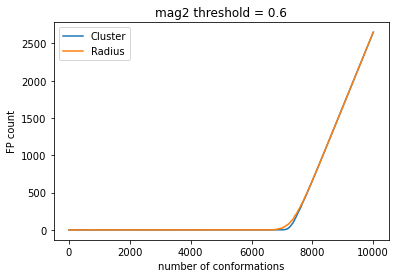

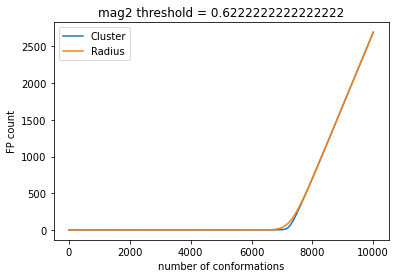

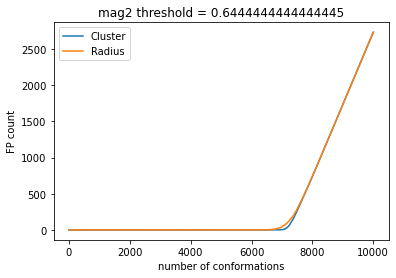

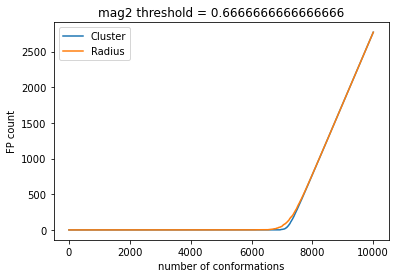

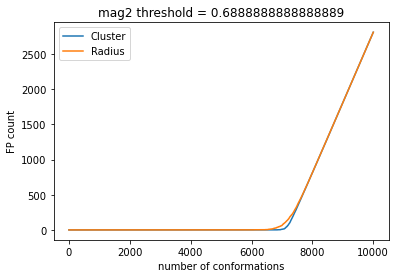

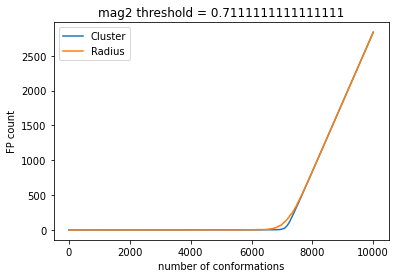

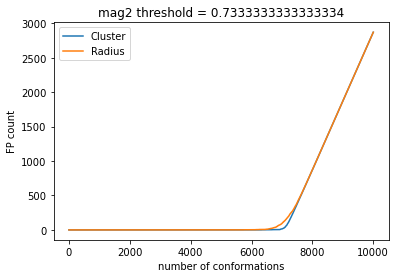

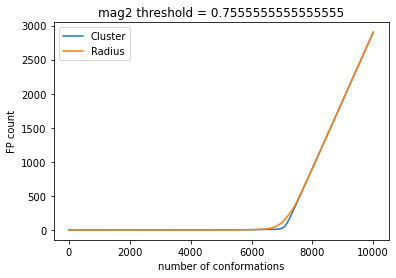

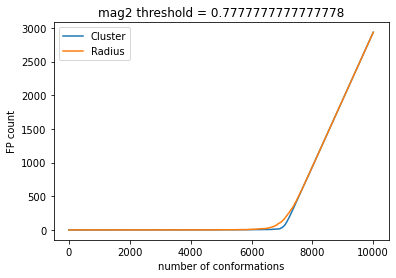

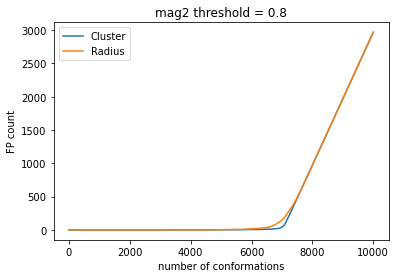

In [35]:
for m_th in np.linspace(0.6, 0.8, 10):
    plt.figure()
    plt.title(f'mag2 threshold = {m_th}')
    plt.xlabel('number of conformations')
    plt.ylabel('FP count')
    k_c = 0
    k_r = 0
    C_arr = []
    R_arr = []
    N = 10000
    step = 200
    for i in range(N):
        if conformations[R_norm[i][1]].mag2[-1].mean < m_th:
            k_r += 1
        if conformations[Max_C[i][1]].mag2[-1].mean < m_th:
            k_c += 1

        C_arr.append(k_c)
        R_arr.append(k_r)

#         if i % step == 0:
#             print(i, f'k_r = {k_r}, k_c = {k_c}, dif = {k_r - k_c}, {i - k_c}')
    
    plt.plot(C_arr, label='Cluster')
    plt.plot(R_arr, label='Radius')
    plt.legend(loc='best')
    plt.show()

## Length 250

In [94]:
conformations = utils.load_Conformations_from_dir('Conformations/L250_beta0.1_1_10(10000)', load_data=True)

In [95]:
clusters, bridges = clusters_and_lines_from_list_2(conformations)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


In [96]:
L = 250

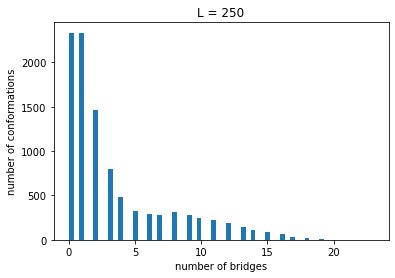

In [97]:
bridges_count = [b.shape[0] for b in bridges]
plt.title(f'L = {L}')
plt.xlabel('number of bridges')
plt.ylabel('number of conformations')
plt.hist(bridges_count, bins='auto')
plt.show()

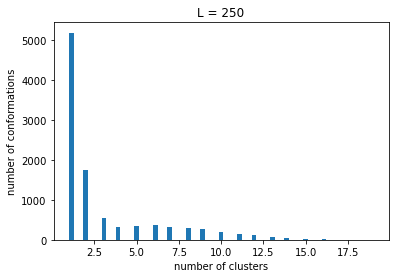

In [98]:
clusters_count = [c.shape[0] for c in clusters]
plt.title(f'L = {L}')
plt.xlabel('number of clusters')
plt.ylabel('number of conformations')
plt.hist(clusters_count, bins='auto')
plt.show()

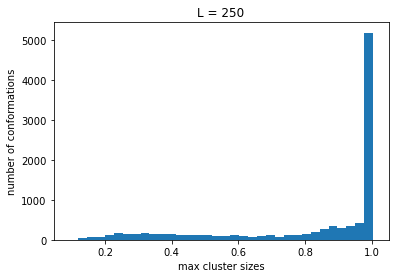

In [99]:
max_cluster = [c.max() / L for c in clusters]
plt.title(f'L = {L}')
plt.xlabel('max cluster sizes')
plt.ylabel('number of conformations')
plt.hist(max_cluster, bins='auto')
plt.show()

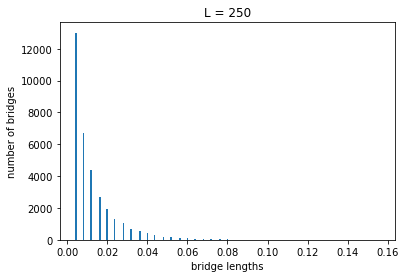

In [100]:
bridge_lengths = []
for br in bridges:
    for b in br:
        bridge_lengths.append(b / L)
plt.title(f'L = {L}')
plt.xlabel('bridge lengths')
plt.ylabel('number of bridges')
plt.hist(bridge_lengths, bins='auto')
plt.show()

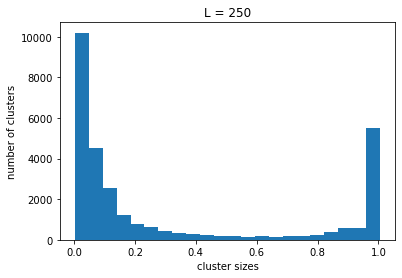

In [101]:
cluster_sizes = []
for cl in clusters:
    for c in cl:
        cluster_sizes.append(c / L)
plt.title(f'L = {L}')
plt.xlabel('cluster sizes')
plt.ylabel('number of clusters')
plt.hist(cluster_sizes, bins='auto')
plt.show()

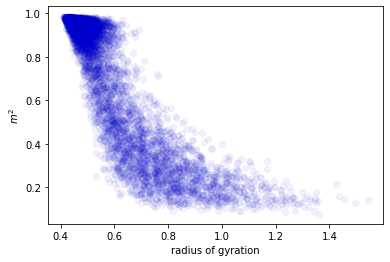

In [12]:
points = []
for i in range(len(conformations)):
    points.append((conformations[i].R_norm, conformations[i].mag2[-1].mean))

points = np.array(points)
plt.xlabel('radius of gyration')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.05));

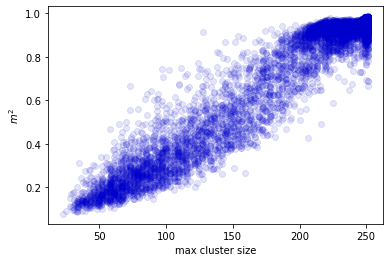

In [16]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    if clusters[i].shape[0] == 0:
        points[i] = (0, conformations[i].mag2[-1].mean)
    else:
        points[i] = (clusters[i].max(), conformations[i].mag2[-1].mean)

plt.xlabel('max cluster size')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.1));

In [102]:
Max_C = []
for i in range(len(clusters)):
    Max_C.append((clusters[i].max(), i))
    
R_norm = []
for i in range(len(conformations)):
    R_norm.append((conformations[i].R_norm, i))

In [103]:
R_norm.sort()
Max_C.sort(reverse=True)

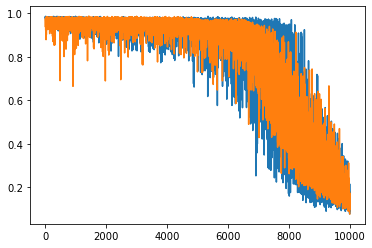

In [104]:
m_R = [conformations[x[1]].mag2[-1].mean for x in R_norm]
m_C = [conformations[x[1]].mag2[-1].mean for x in Max_C]
plt.plot(m_R)
plt.plot(m_C)

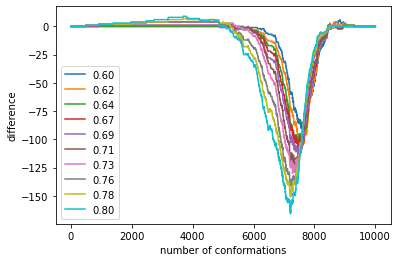

In [106]:
plt.figure()
plt.xlabel('number of conformations')
plt.ylabel('difference')
for m_th in np.linspace(0.6, 0.8, 10):
    k_c = 0
    k_r = 0
    C_arr = []
    R_arr = []
    N = 10000
    step = 200
    for i in range(N):
        if conformations[R_norm[i][1]].mag2[-1].mean < m_th:
            k_r += 1
        if conformations[Max_C[i][1]].mag2[-1].mean < m_th:
            k_c += 1

        C_arr.append(k_c)
        R_arr.append(k_r)

#         if i % step == 0:
#             print(i, f'k_r = {k_r}, k_c = {k_c}, dif = {k_r - k_c}, {i - k_c}')
    
    plt.plot([C_arr[i] - R_arr[i] for i in range(len(C_arr))], label='{:.2f}'.format(m_th))
plt.legend(loc='best')
plt.show()